In [17]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        # DDPG四个网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        # 放入设备
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones) # 对每个元组，用目标网络计算y
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets)) # 自动计算目标的方均误差
        self.critic_optimizer.zero_grad()# 清除累积的梯度
        critic_loss.backward()
        self.critic_optimizer.step()# 通过指定的优化器更新当前Critic网络
 #         因为优化器默认采用梯度下降而非上升，而奖励函数的值是负的，且越负效果越差，所以需要乘以一个负数转换优化方向。
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
    # 为啥是负数？pendulum的奖励函数确实是负的，这个负数如果删除掉会训练出一个“正立摆”
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [4]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 400 # 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
# random.seed(0)
# np.random.seed(0)
# env.seed(0)
# torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  # 经验回放
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|███████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s, episode=400, return=-172.690]


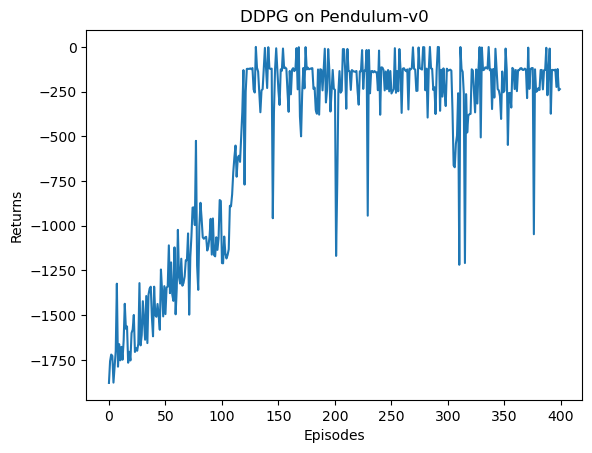

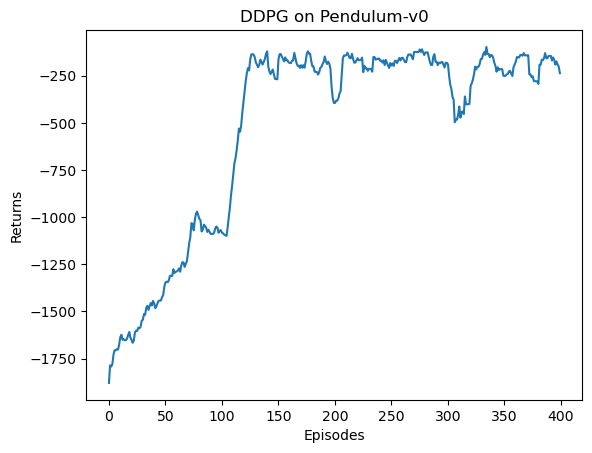

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

# # 运行一个仿真回合
# state = env.reset()
# Agent=agent # agent
# for _ in range(400):
#     env.render()
#     # 在这写更新过程
# #     action = Agent.take_action(state) #### **** 采取动作  agent1
#     state1 = torch.tensor([state], dtype=torch.float).to(device)
#     action = [Agent(state1).item()] # 原本要求输入格式为ndarray，这里发现list竟然也可以
# #     原版是怎么把输出放进向量里的？
# #     print(type(action))
# #   break
#     next_state, reward, done, _ = env.step(action) # 与环境交互更新状态参数，每步新增1个reward
# #     replay_buffer.add(state, action, reward, next_state, done)
#     state = next_state # 更新状态
# #     episode_return += reward
# #     return_list.append(episode_return)
# env.close()

In [9]:
# 保存网络参数
torch.save(agent.actor.state_dict(),"DDPG_actor_test.pth")
torch.save(agent.critic.state_dict(),"DDPG_critic_test.pth")

In [7]:
# 加载网络参数运行一次仿真
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


env_name = 'Pendulum-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


# 加载模型参数
agent1=PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
agent1.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent1.eval()

# 运行一个仿真回合
state = env.reset()
Agent=agent1 # agent
for _ in range(400):
    env.render()
    # 在这写更新过程
#     action = Agent.take_action(state) #### **** 采取动作  agent1
    state1 = torch.tensor([state], dtype=torch.float).to(device)
    action = [Agent(state1).item()] # 原本要求输入格式为ndarray，这里发现list竟然也可以
#     原版是怎么把输出放进向量里的？
#     print(type(action))
#   break
    next_state, reward, done, _ = env.step(action) # 与环境交互更新状态参数，每步新增1个reward
#     replay_buffer.add(state, action, reward, next_state, done)
    state = next_state # 更新状态
#     episode_return += reward
#     return_list.append(episode_return)
env.close()

In [ ]:
如果读档后再训练会怎样？

In [10]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 400 # 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
# random.seed(0)
# np.random.seed(0)
# env.seed(0)
# torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  # 经验回放
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent2 = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

# 训练读档
# agent1=PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
agent2.actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.target_actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
agent2.target_critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
# agent2.eval()


return_list = rl_utils.train_off_policy_agent(env, agent2, num_episodes, replay_buffer, minimal_size, batch_size)


Iteration 9: 100%|███████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s, episode=400, return=-123.777]


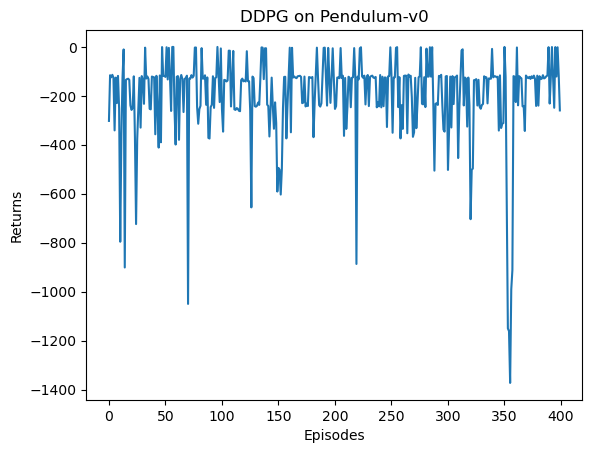

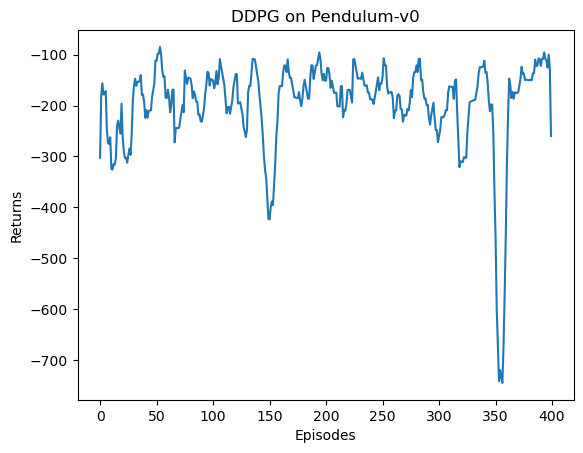

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

## 将读档作为示范用于训练

1、示范时只存经验回放池不更新网络

In [25]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 400 # 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
# random.seed(0)
# np.random.seed(0)
# env.seed(0)
# torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  # 经验回放
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent2 = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)
import copy
agent=copy.deepcopy(agent2)
# 训练读档
# agent1=PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
agent2.actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.target_actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
agent2.target_critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
# agent2.eval()

for i in range(2):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # 进度条
        for i_episode in range(int(num_episodes/10)): # 每个1/10的训练轮次
            episode_return = 0
            state = env.reset()
            done = False
            while not done: # 每个训练回合
                # state_check=state
                # 1.执行动作得到环境反馈
#                 epsilon = (i+9) / 10  # 只示范前1/10的回合
#                 epsilon = np.clip(epsilon, 0.1, 1)
#                 if np.random.random() < epsilon:
                action = agent2.take_action(state) # 示范动作
                next_state, reward, done, _ = env.step(action) # pendulum中的action一定要是ndarray才能输入吗？
                # 2.运行记录添加回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
#                 # 3.从回放池采样更新智能体
#                 if replay_buffer.size() > minimal_size:
#                     b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
#                     transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
#                     agent.update(transition_dict)
#             return_list.append(episode_return)
#             if (i_episode+1) % 10 == 0:
#                 pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
#             pbar.update(1)

return_list = []
# global state_check
for i in range(12):  # 10
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # 进度条
        for i_episode in range(int(num_episodes/10)): # 每个1/10的训练轮次
            episode_return = 0
            state = env.reset()
            done = False
            while not done: # 每个训练回合
                # state_check=state
                # 1.执行动作得到环境反馈
#                 epsilon = (i+9) / 10  # 只示范前1/10的回合
#                 epsilon = np.clip(epsilon, 0.1, 1)
#                 if np.random.random() < epsilon:
#                 if i>1:
                action = agent.take_action(state) # 训练动作
#                 else:
#                     action = agent2.take_action(state) # 示范动作
                    
                next_state, reward, done, _ = env.step(action) # pendulum中的action一定要是ndarray才能输入吗？
                # 2.运行记录添加回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 3.从回放池采样更新智能体
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)
    # return return_list

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

Iteration 11: 100%|██████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s, episode=480, return=-178.197]


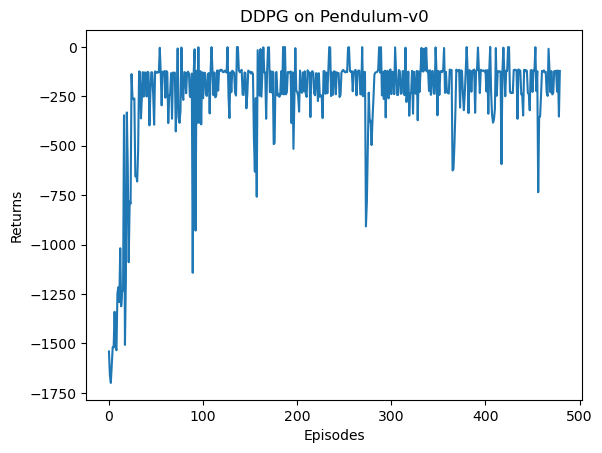

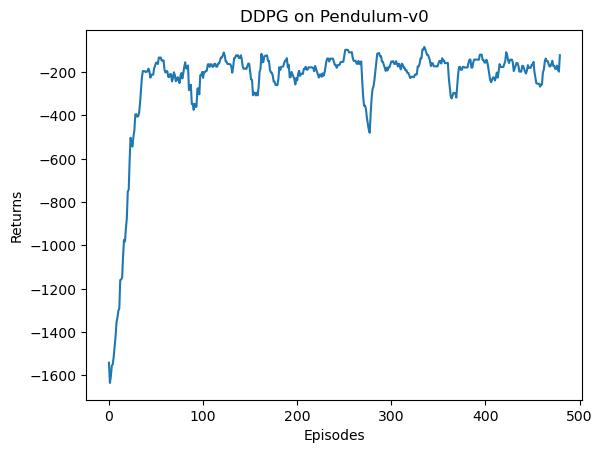

In [26]:

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

2、示范时更新两个网络

In [21]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 400 # 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
# random.seed(0)
# np.random.seed(0)
# env.seed(0)
# torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  # 经验回放
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent2 = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)
import copy
agent=copy.deepcopy(agent2)
# 训练读档
# agent1=PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
agent2.actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.target_actor.load_state_dict(torch.load('DDPG_actor_test.pth')) # 仅加载参数
agent2.critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
agent2.target_critic.load_state_dict(torch.load('DDPG_critic_test.pth')) # 仅加载参数
# agent2.eval()

for i in range(2):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # 进度条
        for i_episode in range(int(num_episodes/10)): # 每个1/10的训练轮次
            episode_return = 0
            state = env.reset()
            done = False
            while not done: # 每个训练回合
                action = agent2.take_action(state) # 示范动作
                next_state, reward, done, _ = env.step(action) # pendulum中的action一定要是ndarray才能输入吗？
                # 2.运行记录添加回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 3.从回放池采样更新智能体
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

return_list = []
# global state_check
for i in range(10):  # 10
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # 进度条
        for i_episode in range(int(num_episodes/10)): # 每个1/10的训练轮次
            episode_return = 0
            state = env.reset()
            done = False
            while not done: # 每个训练回合
                action = agent.take_action(state) # 训练动作
                next_state, reward, done, _ = env.step(action) # pendulum中的action一定要是ndarray才能输入吗？
                # 2.运行记录添加回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 3.从回放池采样更新智能体
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)


Iteration 9: 100%|███████████████████████████████████████| 40/40 [00:33<00:00,  1.18it/s, episode=400, return=-135.375]


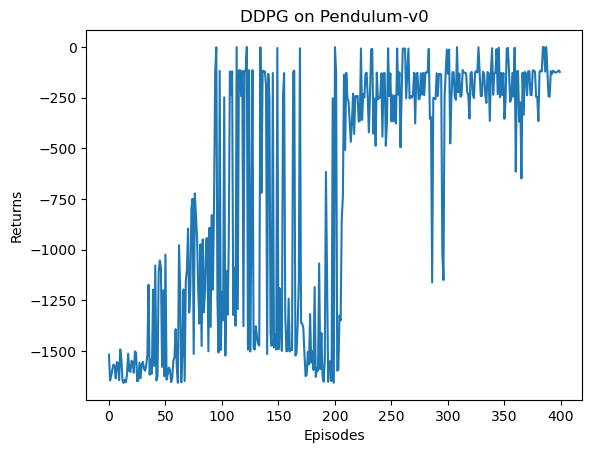

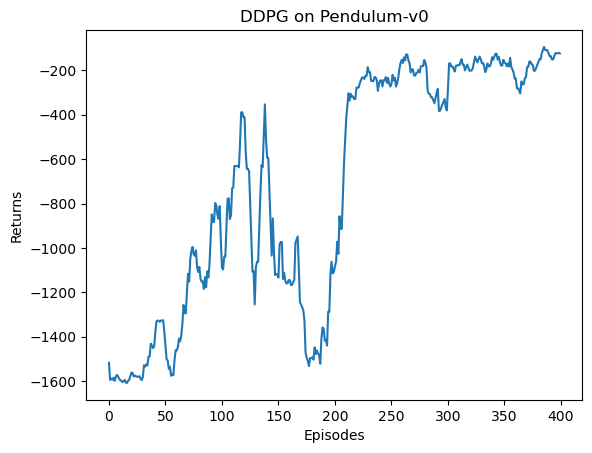

In [22]:

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

epsilon-greedy改

Iteration 9: 100%|███████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s, episode=200, return=-139.374]


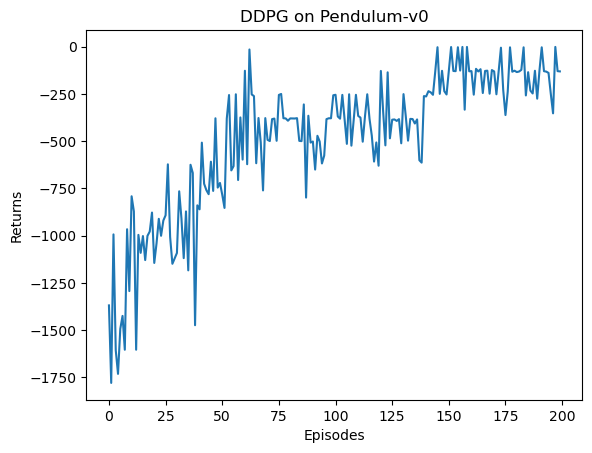

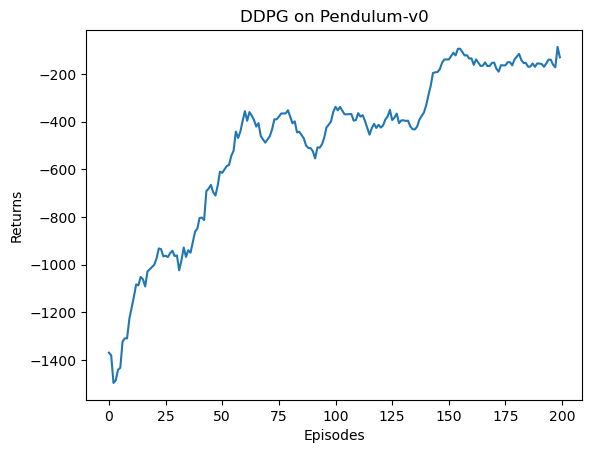

In [15]:
import random
import gym
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# import rl_utils

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


class DDPG:
    ''' DDPG算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        # DDPG四个网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    # def take_action(self, state):
    #     state = torch.tensor([state], dtype=torch.float).to(self.device)
    #     action = self.actor(state).item()
    #     # 给动作添加噪声，增加探索
    #     action = action + self.sigma * np.random.randn(self.action_dim)
    #     return action

    def take_action(self, state, epsilon):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        if np.random.random() < epsilon:
            # 以epsilon概率选择actor的输出
            action = self.actor(state).item()
        else:
            # 以1-epsilon概率选择随机动作
            action = np.random.randn(self.action_dim)
        # 添加噪声
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        # 放入设备
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)  # 对每个元组，用目标网络计算y
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))  # 自动计算目标的方均误差
        self.critic_optimizer.zero_grad()  # 清除累积的梯度
        critic_loss.backward()
        self.critic_optimizer.step()  # 通过指定的优化器更新当前Critic网络
        #         因为优化器默认采用梯度下降而非上升，而奖励函数的值是负的，且越负效果越差，所以需要乘以一个负数转换优化方向。
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        # 为啥是负数？pendulum的奖励函数确实是负的，这个负数如果删除掉会训练出一个“正立摆”
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络


actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 100  # 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)  # 经验回放
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)
# state_check=[] # 查看输入
## todo 打开这里的函数
# def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
return_list = []
# global state_check
for i in range(10):  # 10
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:  # 进度条
        for i_episode in range(int(num_episodes / 10)):  # 每个1/10的训练轮次
            episode_return = 0
            state = env.reset()
            done = False
            epsilon = (i+2) / 10  # 线性衰减
            epsilon = np.clip(epsilon, 0.1, 1)
            while not done:  # 每个训练回合
                # state_check=state
                # 1.执行动作得到环境反馈
                # state = state[0] if len(state) == 2 else state  # test2
                state = state[0] if state[1] == {} else state  # test2
                action = agent.take_action(state, epsilon)
                next_state, reward, done, _ = env.step(action)  # 这条语句要求gym版本得是0.25.1，如果是0.26以后的版本就不能用了
                # if done==True:
                #     print(done)
                # 2.运行记录添加回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 3.从回放池采样更新智能体
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                  'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()
